In [23]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models
from torchinfo import summary

import numpy as np
import os

## Model

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, num_hiddens, num_heads, dropout=0.1):
        super().__init__()
        assert num_hiddens % num_heads == 0
        self.num_heads = num_heads
        self.dropout = dropout
        qkv_bias = False
        self.W_q = nn.LazyLinear(num_hiddens, bias=qkv_bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=qkv_bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=qkv_bias)
        self.W_h = nn.Linear(num_hiddens, num_hiddens)

    def dot_product_attention(self, Q, K, V):
        # input shape:  (batch_size, num_heads, num_patches, num_hiddens/num_heads)
        # output shape: (batch_size, num_heads, num_patches, num_hiddens/num_heads)
        d = Q.shape[-1]
        scores = torch.matmul(Q, K.transpose(-2,-1)) / np.sqrt(d)  # (batch_size, num_heads, num_patches, num_patches)
        A = nn.Softmax(dim=-1)(scores)
        H = torch.matmul(nn.Dropout(self.dropout)(A), V)  # (batch_size, num_heads, num_patches, num_hiddens/num_heads)
        return H
    
    def split_heads(self, X):
        # input:  (batch_size, num_patches, num_hiddens)
        # output: (batch_size, num_heads, num_patches, num_hiddens/num_heads)
        return X.reshape(X.shape[0], X.shape[1], self.num_heads, -1).transpose(1, 2)
    
    def concat_heads(self, X):
        # input:  (batch_size, num_heads, num_patches, num_hiddens/num_heads)
        # output: (batch_size, num_patches, num_hiddens)
        X = X.transpose(1,2)
        return X.reshape(X.shape[0], X.shape[1], -1)

    def forward(self, X):
        # input shape:  (batch_size, num_patches, in_hiddens)
        # return shape: (batch_size,)
        Q = self.split_heads(self.W_q(X))  # (batch_size, num_heads, num_patches, num_hiddens/num_heads)
        K = self.split_heads(self.W_k(X))
        V = self.split_heads(self.W_v(X))
        H = self.dot_product_attention(Q, K, V)  # (batch_size, num_heads, num_patches, num_hiddens/num_heads)
        H = self.W_h(self.concat_heads(H))  # (batch_size, num_patches, num_hiddens)
        return H


class TransformerBlock(nn.Module):
    def __init__(self, num_hiddens, num_heads, mlp_hiddens, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(num_hiddens)
        self.attention = MultiHeadSelfAttention(num_hiddens, num_heads, dropout)
        self.norm2 = nn.LayerNorm(num_hiddens)
        self.mlp = nn.Sequential(
            nn.Linear(num_hiddens, mlp_hiddens),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hiddens, num_hiddens),
            nn.Dropout(dropout)
        )
    
    def forward(self, X):
        X = X + self.attention(self.norm1(X))
        X = X + self.mlp(self.norm2(X))
        return X


class Predictor(nn.Module): 
    def __init__(self, num_hiddens = 512, num_heads = 8, mlp_hiddens = 2048, dropout = 0.1, in_size = (11, 3072, 20, 30), num_layers = 2):
        super().__init__()
        self.num_hiddens = num_hiddens
        T_, C_, H_, W_ = in_size
        self.transformer = nn.Sequential()
        for i in range(num_layers):
            self.transformer.add_module(f"{i}", TransformerBlock(num_hiddens, num_heads, mlp_hiddens, dropout))
        self.linear1 = nn.Linear(C_, self.num_hiddens)
        self.linear2 = nn.Linear(self.num_hiddens, C_)
        self.linear3 = nn.Linear(T_*H_*W_, H_*W_)
        self.relu = nn.ReLU()
        self.pos_embedding = nn.Parameter(0.02 * torch.randn(1, T_*H_*W_, num_hiddens))


    def forward(self, X):
        B, T, C, H, W = X.shape
        # B * 11 * 2048 * 5 * 8 to B * 440 * 2048
        X = X.permute(0,2,1,3,4).reshape(B, C, T*H*W).permute(0,2,1)

        # B * 440 * 2048 to B * 440 * 512
        X = self.linear1(X)
        #add positional embedding
        X = X + self.pos_embedding
        X = self.transformer(X)

        # B * 440 * 512 to B * 440 * 2048
        X = self.linear2(X)
        X = self.relu(X)
        # B * 440 * 2048 to B * 2048 * 40
        X = X.permute(0,2,1)
        X = self.linear3(X)
        X = X.reshape(B, C, H, W)
        return X

In [ ]:
class VideoInstanceSeg(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(replace_stride_with_dilation=[False, True, True])
        self.resnet_aux = nn.Sequential(*list(resnet.children())[:-3])
        self.layer4 = list(resnet.children())[-3]
        self.predictor = Predictor()
        self.classifier = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(512, 49, kernel_size=(1, 1), stride=(1, 1)),
        )
        self.aux_classifier = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(256, 49, kernel_size=(1, 1), stride=(1, 1)),
        )
    
    def forward(self, x):
        # x shape: (B, 11, 3, H, W)
        B = x.shape[0]
        x = x.reshape(B * 11, 3, 160, 240)

        x1 = self.resnet_aux(x) # (B * 11, 1024, 20, 30)
        x2 = self.layer4(x1)    # (B * 11, 2048, 20, 30)
        x = torch.cat([x1, x2], dim=1).reshape(B, 11, 3072, 20, 30)

        x = self.predictor(x)

        x1 = x[:, :1024, :, :]
        x2 = x[:, 1024:, :, :]

        x1 = self.aux_classifier(x1)
        x2 = self.classifier(x2)

        y = {}
        y['out'] = F.interpolate(x2, size=(160, 240), mode="bilinear", align_corners=False)
        y['aux'] = F.interpolate(x1, size=(160, 240), mode="bilinear", align_corners=False)
        return y

model = VideoInstanceSeg()

In [ ]:
backbone_dir = '/Users/louis/Files/deep-learning/Deep-Learning-VQA/ssl/output/backbone-resnet50-0.9167/resnet50_best.pth'

# load backbone
resnet = models.resnet50(replace_stride_with_dilation=[False, True, True])
backbone = nn.Sequential(*list(resnet.children())[:-2])
backbone.load_state_dict(torch.load(backbone_dir, map_location='cpu'), strict=True)
model.resnet_aux.load_state_dict(backbone[:-1].state_dict())
model.layer4.load_state_dict(backbone[-1].state_dict())

In [ ]:
fcn_dir = '/Users/louis/Files/deep-learning/Deep-Learning-VQA/segmentation/output/fcn_resnet50_jaccard_0.9204/'

model.classifier.load_state_dict(torch.load(fcn_dir + 'classifier.pth', map_location='cpu'), strict=True)
model.aux_classifier.load_state_dict(torch.load(fcn_dir + 'aux_classifier.pth', map_location='cpu'), strict=True)

In [ ]:
nn.Sequential(
    nn.Linear(11, 512), 
    nn.ReLU(), 
    nn.Linear(512, 512), 
    nn.ReLU(),
    nn.Linear(512, 1)
)

In [ ]:
3072 * 600 * 11 / 1e6

## Data

In [ ]:
from transforms import SegmentationTrainTransform
from data import ImagesToMaskDataset

data_dir = '/Users/louis/Files/deep-learning/Deep-Learning-VQA/dataset'

transform_train = SegmentationTrainTransform()
dataset_train = ImagesToMaskDataset(os.path.join(data_dir, 'train'), transform_train)

In [ ]:
dataset_train[0][0].shape

In [ ]:
loader_train = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=8,
        shuffle=True,
)

In [ ]:
imgs, targets = next(iter(loader_train))

print(imgs.shape, targets.shape)

In [ ]:
y = model(imgs)

In [ ]:
y.shape

In [ ]:
x = torch.zeros(1, 2048, 3, 4)
y = torch.zeros(1, 1024, 3, 4)
torch.cat([x, y], dim=1).shape

In [ ]:
from torchvision import models

fcn_resnet = models.segmentation.fcn_resnet50(aux_loss=True)
fcn_resnet

In [ ]:
layer = nn.Sequential(
    nn.Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Conv2d(512, 49, kernel_size=(1, 1), stride=(1, 1)),
)

In [ ]:

layer(x).shape

In [ ]:
import torch.nn.functional as F

x = torch.randn((1, 49, 20, 30))

y = F.interpolate(x, size=(160, 240), mode="bilinear", align_corners=False)

In [ ]:
y.shape

In [ ]:
resnet = models.resnet50(replace_stride_with_dilation=[False, True, True])

In [ ]:
summary(resnet, input_size=(1, 3, 160, 240))

In [ ]:
resnet_aux = nn.Sequential(*list(resnet.children())[:-3])

In [ ]:
summary(resnet_aux, input_size=(1, 3, 160, 240))

In [ ]:
list(resnet.children())[-3]
resnet.layer4

## Inference

In [15]:
class VideoInstanceSeg(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(replace_stride_with_dilation=[False, True, True])
        self.resnet_aux = nn.Sequential(*list(resnet.children())[:-3])
        self.layer4 = list(resnet.children())[-3]
        self.predictor = Predictor()
        self.classifier = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(512, 49, kernel_size=(1, 1), stride=(1, 1)),
        )
        self.aux_classifier = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(256, 49, kernel_size=(1, 1), stride=(1, 1)),
        )
    
    def forward(self, x):
        # x shape: (B, 11, 3, H, W)
        B = x.shape[0]
        x = x.view(B * 11, 3, 160, 240)

        x1 = self.resnet_aux(x) # (B * 11, 1024, 20, 30)
        x2 = self.layer4(x1)    # (B * 11, 2048, 20, 30)

        x = torch.cat([x1, x2], dim=1).view(B, 11, 3072, 20, 30)

        x = self.predictor(x)

        x1 = x[:, :1024, :, :]
        x2 = x[:, 1024:, :, :]

        x1 = self.aux_classifier(x1)
        x2 = self.classifier(x2)

        y = {}
        y['out'] = F.interpolate(x2, size=(160, 240), mode="bilinear", align_corners=False)
        y['aux'] = F.interpolate(x1, size=(160, 240), mode="bilinear", align_corners=False)
        return y



class Predictor(nn.Module):
    def __init__(self, num_hiddens = 256, num_heads = 4, mlp_hiddens = 1024, dropout = 0.1, in_size = (11, 3072, 20, 30), num_layers = 1):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(11, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        B, T, C, H, W = x.shape
        # B * 11 * 2048 * 5 * 8 to B * 440 * 2048

        x = x.permute(0,2,3,4,1)

        x = self.fc(x).squeeze(-1)

        return x

In [271]:
class VideoInstanceSeg(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(replace_stride_with_dilation=[False, True, True])
        self.resnet_aux = nn.Sequential(*list(resnet.children())[:-3])
        self.layer4 = list(resnet.children())[-3]
        self.predictor = Predictor()
        self.classifier = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(512, 49, kernel_size=(1, 1), stride=(1, 1)),
        )
        self.aux_classifier = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(256, 49, kernel_size=(1, 1), stride=(1, 1)),
        )
    
    def forward(self, x):
        # x shape: (B, 11, 3, H, W)
        B = x.shape[0]
        x = x.view(B * 11, 3, 160, 240)

        x1 = self.resnet_aux(x) # (B * 11, 1024, 20, 30)
        x2 = self.layer4(x1)    # (B * 11, 2048, 20, 30)

        x1 = x1.view(B, 11, 1024, 20, 30)
        x2 = x2.view(B, 11, 2048, 20, 30)

        x1 = self.predictor(x1)
        y = self.predictor(x2)
        y += x2.mean(dim=1)


        x1 = self.aux_classifier(x1)
        y = self.classifier(y)

        output = {}
        output['out'] = F.interpolate(y, size=(160, 240), mode="bilinear", align_corners=False)
        output['aux'] = F.interpolate(x1, size=(160, 240), mode="bilinear", align_corners=False)

        return output


class Predictor(nn.Module):
    def __init__(self, num_hiddens = 256, num_heads = 4, mlp_hiddens = 1024, dropout = 0.1, in_size = (11, 3072, 20, 30), num_layers = 1):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(11, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        B, T, C, H, W = x.shape
        # B * 11 * 2048 * 5 * 8 to B * 440 * 2048

        x = x.permute(0,2,3,4,1)

        x = self.fc(x).squeeze(-1)

        return x


In [272]:
model = VideoInstanceSeg()

In [273]:
path = '/Users/louis/Files/deep-learning/Deep-Learning-VQA/main/output/model_main/model_best.pth'
path = '/Users/louis/Files/deep-learning/Deep-Learning-VQA/main/output/20230428-141156/model_best.pth'

device = 'mps'

model.load_state_dict(torch.load(path, map_location='cpu'))
model = model.to(device)

In [274]:
data_dir = '/Users/louis/Files/deep-learning/Deep-Learning-VQA/dataset'

from transforms import SegmentationTrainTransform, SegmentationValTransform
from data import ImagesToMaskDataset

transform_train = SegmentationValTransform()
dataset_train = ImagesToMaskDataset(os.path.join(data_dir, 'val'), transform_train)

In [275]:
loader_train = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=1,
        shuffle=True,
)

In [291]:
imgs, targets = next(iter(loader_train))
imgs = imgs.to(device)

outputs = model(imgs)
outs = outputs['out'].cpu().detach().numpy()
out_pred = outs.argmax(1)
out_pred.shape

(1, 160, 240)

array([ 0,  1,  6, 10, 22, 36, 48])

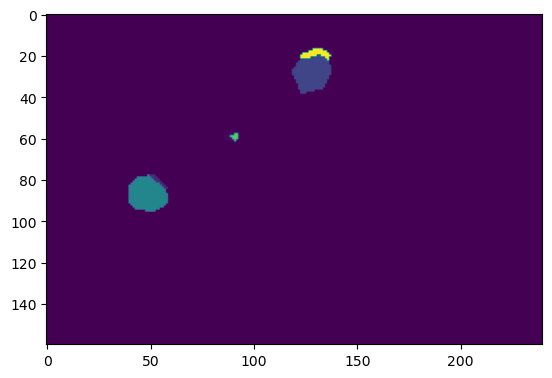

In [292]:
import matplotlib.pyplot as plt

plt.imshow(out_pred[0])
out_pred.max()
np.unique(out_pred[0])

array([ 0,  4,  5, 19, 22, 42, 47])

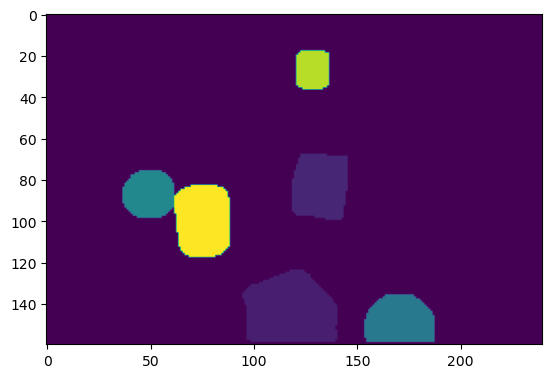

In [293]:
plt.imshow(targets[0].cpu())
np.unique(targets[0])

In [97]:
x1.mean(dim=1).shape

torch.Size([8, 1024, 20, 30])